Results Section

- Dipole Auger + 2MRS Dipoles in >cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------

- Dipole Auger + 2MRS Dipoles in slices of cz (with flux weight)
- Angular distance to Auger Dipole
- [Use full Sample]
---------------------
- Galaxy-Flux correlation for different cz
- [Use sample with completeness]
---------------------

- G-F correlation at closest cz for different K
- [Use sample with completeness]



### Read Full Catalogue

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df


# Load Data
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
df = read_GLADE(cols)


/tmp/ipykernel_12859/343775168.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 144134


Number of galaxies: 144134


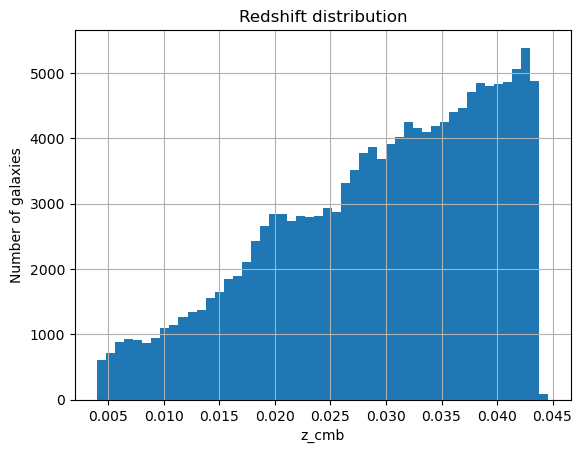

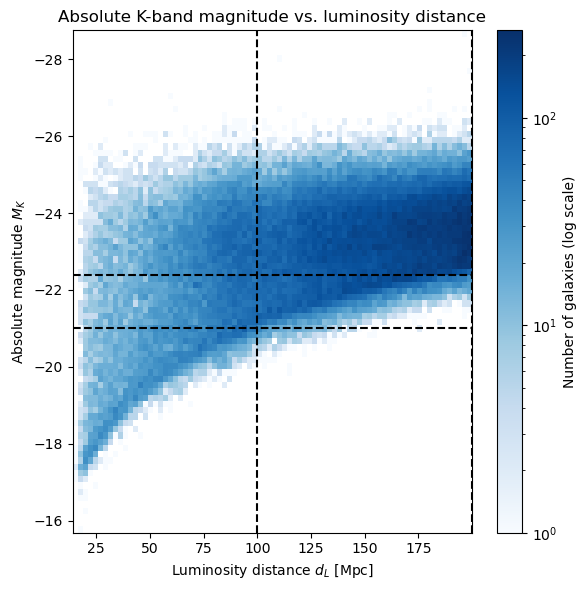

In [9]:

# ----------------------------
# INSPECT DATA
# ----------------------------
print("Number of galaxies:", len(df))


# Redshift distribution
def plot_redshift_distribution(df):
    plt.figure()
    df['z_cmb'].hist(bins=50)
    plt.xlabel("z_cmb")
    plt.ylabel("Number of galaxies")
    plt.title("Redshift distribution")
    plt.show()

### Plot K vs cz
def plot_MK_vs_dL(df):
    from matplotlib.colors import LogNorm
    plt.figure(figsize=(6, 6))
    plt.hist2d(
        df["d_L"],
        df["M_K"],
        bins=80,
        cmap='Blues',
        norm=LogNorm()
    )
    # Reference lines
    plt.axvline(x=100, color='k', linestyle='dashed')
    plt.axvline(x=200, color='k', linestyle='dashed')
    plt.axhline(-21, color='k', linestyle='dashed')
    plt.axhline(-22.4, color='k', linestyle='dashed')
    # Labels and style
    plt.xlabel("Luminosity distance $d_L$ [Mpc]")
    plt.ylabel("Absolute magnitude $M_K$")
    plt.title("Absolute K-band magnitude vs. luminosity distance")
    plt.gca().invert_yaxis()  # brighter = up
    # Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of galaxies (log scale)")
    plt.tight_layout()
    plt.show()

plot_redshift_distribution(df)
plot_MK_vs_dL(df)

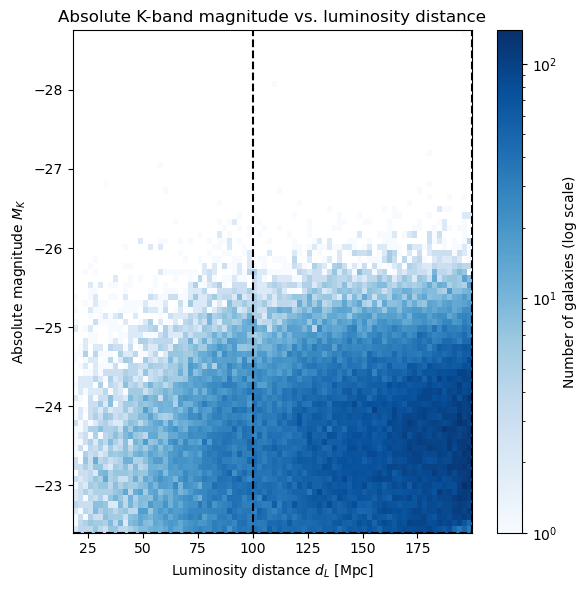

In [10]:
df_K = df[df["M_K"]<-22.4]

# Plot
plot_MK_vs_dL(df_K)



=== Dipole for Full Sample ===
N = 52796 galaxies
RA = 170.95° ± 3.30° (± 3.08° bootstrapped)
Dec = -4.23° ± 3.30° (± 2.90° bootstrapped)
Amplitude = 0.0576 ± 0.0034
Significance = inf sigma (p = 2.22e-66)
Angular separation from Auger = 70.89° ± 3.06°

=== Dipole for 1000-1500 km/s ===
N = 82 galaxies
RA = 179.76° ± 14.22° (± 11.42° bootstrapped)
Dec = 12.53° ± 14.22° (± 11.33° bootstrapped)
Amplitude = 0.3560 ± 0.0945
Significance = 3.43 sigma (p = 2.99e-04)
Angular separation from Auger = 85.96° ± 12.27°

=== Dipole for 1500-2000 km/s ===
N = 305 galaxies
RA = 94.47° ± 11.78° (± 14.32° bootstrapped)
Dec = -47.70° ± 11.78° (± 6.09° bootstrapped)
Amplitude = 0.2986 ± 0.0447
Significance = 4.33 sigma (p = 7.32e-06)
Angular separation from Auger = 24.11° ± 6.13°

=== Dipole for 2000-2500 km/s ===
N = 381 galaxies
RA = 157.64° ± 7.73° (± 8.05° bootstrapped)
Dec = -18.79° ± 7.73° (± 7.70° bootstrapped)
Amplitude = 0.3498 ± 0.0370
Significance = 7.01 sigma (p = 1.19e-12)
Angular separatio

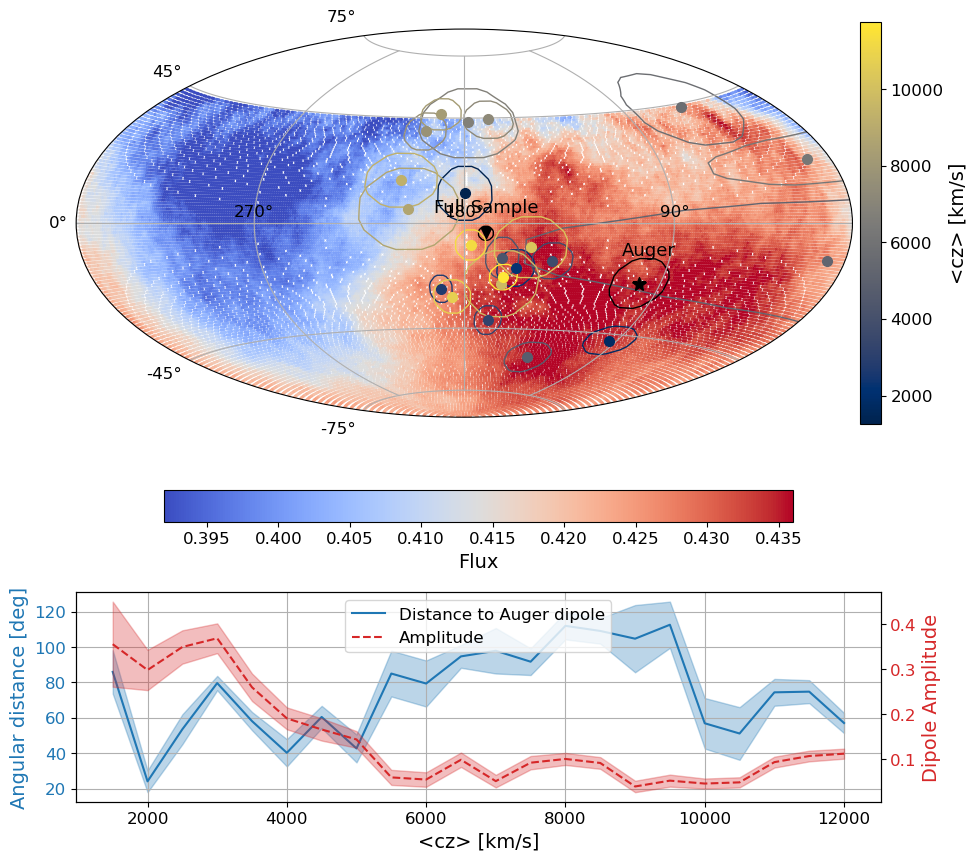

In [16]:

def dipoles_plot(df, plotname):

    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.special import erfinv
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    from matplotlib.patches import Ellipse
    import matplotlib.colors as colors
    from matplotlib.cm import ScalarMappable

    RA_all = np.deg2rad(df['RA'])
    Dec_all = np.deg2rad(df['Dec'])
    cz_all = df['cz']
    #weights_all = np.ones(len(RA_all))
    weights_all = 10**(-.4 * df['M_K']) # Use K-band Luminosity as weights

    # === Load flux cataloge ===
    # Load flux data
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)

    # Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    # Convert to radians
    ra_rad = np.radians(flux_ra)
    dec_rad = np.radians(flux_dec)

    # Shift RA to put RA=0° on right edge, increase leftward
    ra_shifted = np.remainder(ra_rad + np.pi, 2 * np.pi)
    ra_shifted[ra_shifted > np.pi] -= 2 * np.pi
    ra_shifted = -ra_shifted  # flip to increase leftward


    # === Define cz bins ===
    # cz_bins = [
    #     (1200, 9000),       # Full sample
    #     (1200, 3600),
    #     (4000, 5000),
    #     (9000, 9400)
    # ]
    cz_bins = [(cz, cz + 500) for cz in range(1000, 12000, 500)]
    cz_bins.insert(0, (1000, 12000))  # Add full sample as first bin

    # === Setup colors and storage ===
    #n_bins = len(cz_bins)
    dipole_results = {}
    # Normalize cz range for colormap
    cz_vals = [0.5 * (cz_min + cz_max) for (cz_min, cz_max) in cz_bins]
    cz_norm = mcolors.Normalize(vmin=min(cz_vals[1:]), vmax=max(cz_vals[1:]))  # exclude full sample from colormap range
    cmap = cm.cividis  # or try 'viridis', 'turbo', 'cividis'
    #import seaborn as sns
    #cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

    # === Auger reference dipole ===
    auger_RA = 100.0
    auger_Dec = -24.0
    auger_coord = SkyCoord(ra=auger_RA * u.deg, dec=auger_Dec * u.deg, frame='icrs')
    #auger_error_deg = 10.0  # Typical uncertainty in Auger dipole direction
    auger_error_ra_deg = 10.0  # Uncertainty in RA
    auger_error_dec_deg = 13.0  # Uncertainty in Dec

    # === Loop through bins ===
    for i, (cz_min, cz_max) in enumerate(cz_bins):
        label = "Full Sample" if i == 0 else f"{cz_min}-{cz_max} km/s"
        cz_mid = 0.5 * (cz_min + cz_max)
        color = 'k' if i == 0 else cmap(cz_norm(cz_mid))  # gray for full sample, colormap for bins

        # Filter galaxies
        mask = (cz_all > cz_min) & (cz_all < cz_max)
        RA = np.array(RA_all[mask])
        Dec = np.array(Dec_all[mask])
        weights = np.array(weights_all[mask])

        if len(RA) < 10:
            print(f"Skipping {label} — too few galaxies ({len(RA)})")
            continue

        W = np.sum(weights)

        # === 2D Rayleigh dipole ===
        a_alpha = (2.0 / W) * np.sum(weights * np.cos(RA))
        b_alpha = (2.0 / W) * np.sum(weights * np.sin(RA))
        r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
        #phi_alpha_deg = np.rad2deg(np.arctan2(b_alpha, a_alpha) % (2 * np.pi))

        # === 3D dipole direction ===
        x = np.cos(Dec) * np.cos(RA)
        y = np.cos(Dec) * np.sin(RA)
        z = np.sin(Dec)
        X = np.sum(weights * x)
        Y = np.sum(weights * y)
        Z = np.sum(weights * z)
        norm = np.sqrt(X**2 + Y**2 + Z**2)
        X /= norm
        Y /= norm
        Z /= norm

        dipole_amp = norm / W
        alpha_d = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
        delta_d = np.arcsin(Z) * 180 / np.pi

        # === Uncertainty and significance ===
        Weff = W**2 / np.sum(weights**2)                # Effective weight
        sigma_r = np.sqrt(2 / Weff)                     # Uncertainty in radial component
        sigma_phi_deg = np.rad2deg(sigma_r / r_alpha)   # Rough approximation
        sigma_dec_deg = sigma_phi_deg                   # rough approximation
        P_rayleigh = np.exp(-Weff * r_alpha**2 / 4)     # Rayleigh p-value
        Zsig = np.sqrt(2) * erfinv(1 - 2 * P_rayleigh)  # Gaussian significance

        # === Angular separation from Auger dipole ===
        dip_coord = SkyCoord(ra=alpha_d * u.deg, dec=delta_d * u.deg, frame='icrs')
        separation = dip_coord.separation(auger_coord).deg

        # === Store results ===
        dipole_results[label] = {
            'RA': alpha_d,
            'Dec': delta_d,
            'r_alpha': r_alpha,
            'd_perp': dipole_amp,
            'sigma_r': sigma_r,
            'sigma_phi': sigma_phi_deg,
            'sigma_dec': sigma_dec_deg,
            'Z': Zsig,
            'P': P_rayleigh,
            'separation': separation,
            'N': len(RA),
            'color': color
        }

        # === Bootstrap dipole errors ===
        n_bootstrap = 500
        dipole_ras = []
        dipole_decs = []
        dipole_amps_bs = []
        sep_bs = []

        for _ in range(n_bootstrap):
            indices = np.random.choice(len(RA), size=len(RA), replace=True)
            RA_bs = RA[indices]
            Dec_bs = Dec[indices]
            weights_bs = weights[indices]


            x = np.cos(Dec_bs) * np.cos(RA_bs)
            y = np.cos(Dec_bs) * np.sin(RA_bs)
            z = np.sin(Dec_bs)

            X = np.sum(weights_bs * x)
            Y = np.sum(weights_bs * y)
            Z = np.sum(weights_bs * z)
            norm = np.sqrt(X**2 + Y**2 + Z**2)
            X /= norm
            Y /= norm
            Z /= norm

            amp = norm / np.sum(weights_bs)
            ra_bs = (np.arctan2(Y, X) % (2 * np.pi)) * 180 / np.pi
            dec_bs = np.arcsin(Z) * 180 / np.pi

            dipole_ras.append(ra_bs)
            dipole_decs.append(dec_bs)
            dipole_amps_bs.append(amp)

            # Angular separation with Auger dipole
            dip_coord_bs = SkyCoord(ra=ra_bs * u.deg, dec=dec_bs * u.deg, frame='icrs')
            sep = dip_coord_bs.separation(auger_coord).deg
            sep_bs.append(sep)

        # === Bootstrap uncertainties ===
        sigma_ra_boot = np.std(dipole_ras)
        sigma_dec_boot = np.std(dipole_decs)
        sigma_amp_boot = np.std(dipole_amps_bs)
        sigma_sep_boot = np.std(sep_bs)

        dipole_results[label].update({
            'sigma_ra_boot': sigma_ra_boot,
            'sigma_dec_boot': sigma_dec_boot,
            'sigma_amp_boot': sigma_amp_boot,
            'sigma_sep_boot': sigma_sep_boot
        })

        # === Print result ===
        print(f"\n=== Dipole for {label} ===")
        print(f"N = {len(RA)} galaxies")
        print(f"RA = {alpha_d:.2f}° ± {sigma_phi_deg:.2f}° (± {sigma_ra_boot:.2f}° bootstrapped)")
        print(f"Dec = {delta_d:.2f}° ± {sigma_dec_deg:.2f}° (± {sigma_dec_boot:.2f}° bootstrapped)")
        print(f"Amplitude = {dipole_amp:.4f} ± {sigma_amp_boot:.4f}")
        print(f"Significance = {Zsig:.2f} sigma (p = {P_rayleigh:.2e})")
        print(f"Angular separation from Auger = {separation:.2f}° ± {sigma_sep_boot:.2f}°")


    # === Set up top and bottom subplots ===
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1])
    ax_top = fig.add_subplot(gs[0], projection='hammer')
    ax_bottom = fig.add_subplot(gs[1])
    ax_top.grid(True)

    # === Set fontsizrs ===

    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    # === Configure Hammer (Top) Axis ===
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax_top.set_xticks(xticks_rad)
    ax_top.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax_top.set_yticks(yticks_rad)
    ax_top.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Plot flux on sky ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    # === Remove NaNs from flux_val and corresponding positions ===
    mask = np.isfinite(flux_val)
    ra_shifted = ra_shifted[mask]
    dec_rad = np.radians(flux_dec[mask])
    flux_val = flux_val[mask]
    sc = ax_top.scatter(ra_shifted, dec_rad, c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for flux
    cbar_flux = fig.colorbar(sc, ax=ax_top, orientation='horizontal', pad=-.1, fraction=0.05)
    cbar_flux.set_label("Flux")

    # === Plot dipoles ===
    for label, res in dipole_results.items():
        ra_rad = np.deg2rad(res['RA'])
        dec_rad = np.deg2rad(res['Dec'])
        ra_plot = -ra_rad + np.pi  # <- RA increases right to left
        color = res['color']
        amp = res['d_perp']

        marker = 'o' if label != 'Full Sample' else 'v'
        ax_top.plot(ra_plot, dec_rad, marker, color=color, label=label, markersize=7)

        ellipse = Ellipse(
            (ra_plot, dec_rad),
            width=2*np.deg2rad(res['sigma_ra_boot']),
            height=2*np.deg2rad(res['sigma_dec_boot']),
            angle=0,
            edgecolor=color,
            facecolor='none',
            alpha=1,
            transform=ax_top.transData
        )
        ax_top.add_patch(ellipse)

        if label == 'Full Sample':
            ax_top.text(ra_plot, dec_rad + 0.15, label, ha='center', color='k', size=13)

    # Auger point and ellipse
    auger_ra_plot = -np.deg2rad(auger_RA) + np.pi
    auger_dec_rad = np.deg2rad(auger_Dec)
    ax_top.plot(auger_ra_plot, auger_dec_rad, 'k*', markersize=10, label='Auger Dipole')
    ellipse = Ellipse(
        (auger_ra_plot, auger_dec_rad),
        width=2*np.deg2rad(auger_error_dec_deg),
        height=2*np.deg2rad(auger_error_ra_deg),
        angle=0,
        edgecolor='k',
        facecolor='none',
        alpha=1,
        transform=ax_top.transData
    )
    ax_top.add_patch(ellipse)
    ax_top.text(auger_ra_plot, auger_dec_rad + 0.2, "Auger", ha='center', color='k', size=13)
    #ax_top.set_title("Galaxy Dipole Directions with Error Circles (Equatorial)", pad=40)

    # Vertical cz colorbar
    sm = ScalarMappable(cmap=cmap, norm=cz_norm)
    sm.set_array([])
    cbar_cz = fig.colorbar(sm, ax=ax_top, orientation='vertical', pad=0.01, fraction=0.025)
    cbar_cz.set_label("<cz> [km/s]")

    # === Bottom Plot: Dipole amp & separation ===
    cz_bin_centers = []
    angular_separations = []
    dipole_amps = []
    ang_diam_dists = []

    for label, res in dipole_results.items():
        if label == "Full Sample":
            continue

        cz_mid = float(label.split('-')[0]) + 500
        cz_bin_centers.append(cz_mid)
        angular_separations.append(res['separation'])
        dipole_amps.append(res['d_perp'])

        cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
        z = cz_mid / 3e5
        d_ang = cosmo.angular_diameter_distance(z).value
        ang_diam_dists.append(d_ang)

    x = cz_bin_centers
    sep_errors = [dipole_results[label]['sigma_sep_boot'] for label in dipole_results if label != "Full Sample"]
    amp_errors = [dipole_results[label]['sigma_amp_boot'] for label in dipole_results if label != "Full Sample"]

    # Angular separation on left y-axis
    color1 = 'C0'
    ax_bottom.fill_between(x, np.array(angular_separations)-np.array(sep_errors), np.array(angular_separations)+np.array(sep_errors), color=color1, alpha=0.3)
    ln1 = ax_bottom.plot(x, angular_separations, ls='-', color=color1, label='Distance to Auger dipole')
    ax_bottom.set_ylabel("Angular distance [deg]", color=color1)
    ax_bottom.tick_params(axis='y', labelcolor=color1)
    ax_bottom.grid(True)

    # Dipole amplitude on right y-axis
    ax2 = ax_bottom.twinx()
    color2 = 'C3'
    ax2.fill_between(x, np.array(dipole_amps)-np.array(amp_errors), np.array(dipole_amps)+np.array(amp_errors), color=color2, alpha=0.3)
    ln2 = ax2.plot(x, dipole_amps, ls='--', color=color2, label='Amplitude')
    ax2.set_ylabel("Dipole Amplitude", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # X-axis
    ax_bottom.set_xlabel("<cz> [km/s]")

    # Legend
    lines = ln1 + ln2  # flatten the list of lines
    labels = [l.get_label() for l in lines]
    ax_bottom.legend(lines, labels, loc='upper center')


    #ax_bottom.set_title("Dipole Angular Separation and Amplitude vs cz")
    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 14,     # x/y labels
        #'axes.titlesize': 18,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })

    plt.tight_layout()
    plt.savefig(plotname, dpi=300)
    plt.show()


df_K_spec = df_K[df_K['dist_flag'] == 3]

dipoles_plot(df_K_spec, plotname='../plots/plot1_GLADEspec_paper1.png')



=== Dipole for Full Sample ===
N = 29670 galaxies
RA = 35.44° ± 1.66° (± 1.56° bootstrapped)
Dec = 45.96° ± 1.66° (± 0.92° bootstrapped)
Amplitude = 0.2353 ± 0.0052
Significance = inf sigma (p = 4.16e-260)
Angular separation from Auger = 91.12° ± 1.17°

=== Dipole for 1000-1500 km/s ===
N = 10 galaxies
RA = 176.07° ± 28.42° (± 30.63° bootstrapped)
Dec = 20.10° ± 28.42° (± 8.83° bootstrapped)
Amplitude = 0.6390 ± 0.1983
Significance = 1.12 sigma (p = 1.31e-01)
Angular separation from Auger = 86.18° ± 17.86°

=== Dipole for 1500-2000 km/s ===
N = 45 galaxies
RA = 184.76° ± 43.62° (± 49.20° bootstrapped)
Dec = -9.92° ± 43.62° (± 29.53° bootstrapped)
Amplitude = 0.1918 ± 0.0926
Significance = 0.20 sigma (p = 4.22e-01)
Angular separation from Auger = 81.24° ± 29.24°

=== Dipole for 2000-2500 km/s ===
N = 71 galaxies
RA = 147.79° ± 14.90° (± 12.89° bootstrapped)
Dec = -15.44° ± 14.90° (± 15.10° bootstrapped)
Amplitude = 0.3149 ± 0.0788
Significance = 3.23 sigma (p = 6.17e-04)
Angular separa

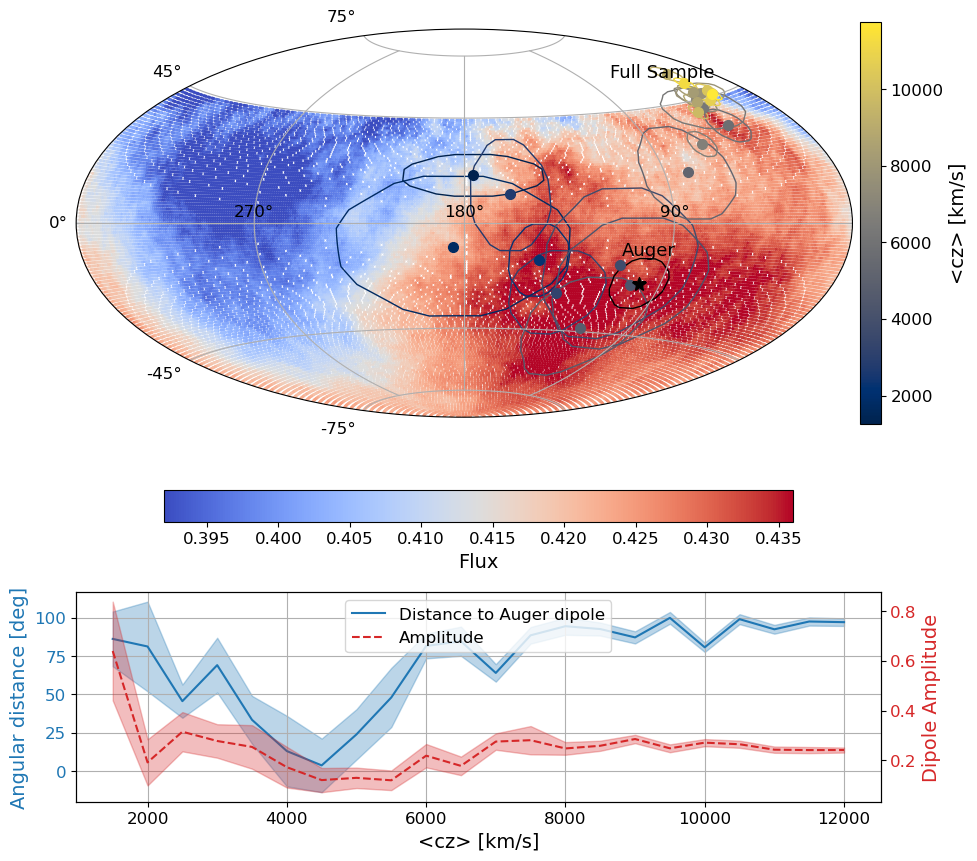

In [17]:
df_K_phot = df_K[df_K['dist_flag'] == 1]

dipoles_plot(df_K_phot, plotname='../plots/plot1_GLADEphot_paper1.png')